## 寻找配对
- 根据累积收益率最小距离筛选pairs

In [1]:
import pickle
from itertools import combinations
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("data/preprocessed.csv")
with open("data/cumReturn.bin", "rb") as f:
    returns = pickle.load(f)

In [3]:
data.head()

,date,asset,close,volume
0,2017-01-03,LLDPE,9710.0,415780.0
1,2017-01-03,PTA,5446.0,2106438.0
2,2017-01-03,动力煤,493.0,102390.0
3,2017-01-03,天然橡胶,18360.0,352158.0
4,2017-01-03,棉花,15085.0,184116.0


In [4]:
assets = returns.keys()

In [5]:
def calSSD(x1, x2):
    '''
    @Description
    计算两个序列的距离，返回square sum of deviation
    ------------
    @Params
    x1, x2, Series
    ------------
    @Returns
    ssd, float
    '''
    return np.sum((x1-x2)**2)

In [6]:
def normalize(x):
    '''
    @Description
    min-max归一
    ------------
    @Params
    x, Series
    ------------
    @Returns
    x1, Series
    '''
    return (x-x.min())/(x.max()-x.min())

In [7]:
# 指定形成期12个月
dates = data["date"].unique()
print(len(dates))

1075


In [8]:
dates

array(['2017-01-03', '2017-01-04', '2017-01-05', ..., '2021-06-02',
       '2021-06-03', '2021-06-04'], dtype=object)

In [9]:
form_days = sum(dates<="2018-01-03")

In [10]:
form_days

246

In [11]:
end_date = sum(dates<="2018-07-03")

In [12]:
end_date

365

In [13]:
# 两两组合计算SSD
SSDs = {}
for asset1, asset2 in combinations(assets, 2):
    # 去除第一个NaN后，应该是[0:form_days-1]
    return1 = normalize(returns[asset1].dropna().values[:form_days-1])
    return2 = normalize(returns[asset2].dropna().values[:form_days-1])
    SSDs[f"{asset1}-{asset2}"] = calSSD(return1, return2)

In [14]:
min(SSDs,key=SSDs.get)

'热轧卷板-螺纹钢'

In [15]:
SSDs["热轧卷板-螺纹钢"]

2.0965845977013613

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from matplotlib.font_manager import FontProperties
# zhfont = FontProperties(fname="/System/Library/Fonts/PingFang.ttc")

In [17]:
# 形成期
# data[data["asset"]=="热轧卷板"].iloc[:form_days,:]

In [18]:
# 交易期
# data[data["asset"]=="热轧卷板"].iloc[form_days:end_date,:]

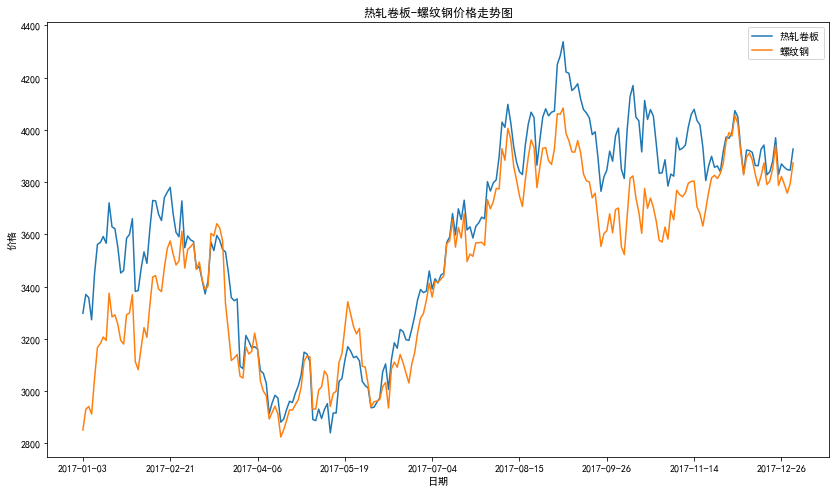

In [20]:
fig, ax = plt.subplots(figsize=(14, 8))
d1 = data[data["asset"]=="热轧卷板"].iloc[:245,:]
d2 = data[data["asset"]=="螺纹钢"].iloc[:245, :]
ax.plot(d1.date, d1.close, label=u"热轧卷板")
ax.plot(d2.date, d2.close, label=u"螺纹钢")
# plt.tight_layout()
# ax.legend(prop=zhfont)
ax.legend()
ax.set_xlabel(u"日期")
ax.set_ylabel(u"价格")
ax.set_title(u"热轧卷板-螺纹钢价格走势图")
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30))
plt.show()

In [42]:
# 按SSD大小排序
SSDs = sorted(SSDs.items(), key=lambda d:d[1])
# 导出
# with open("data/SSDs.bin", "wb") as f:
#     pickle.dump(SSDs, f)

In [44]:
# test 读入
# with open("data/SSDs.bin", "rb") as f:
#     SSDs = pickle.load(f)

## 相关性热力图
- 根据形成期作图
- 挑选出最前面的几个品种作图

In [21]:
# 相关性热力图
import seaborn as sns

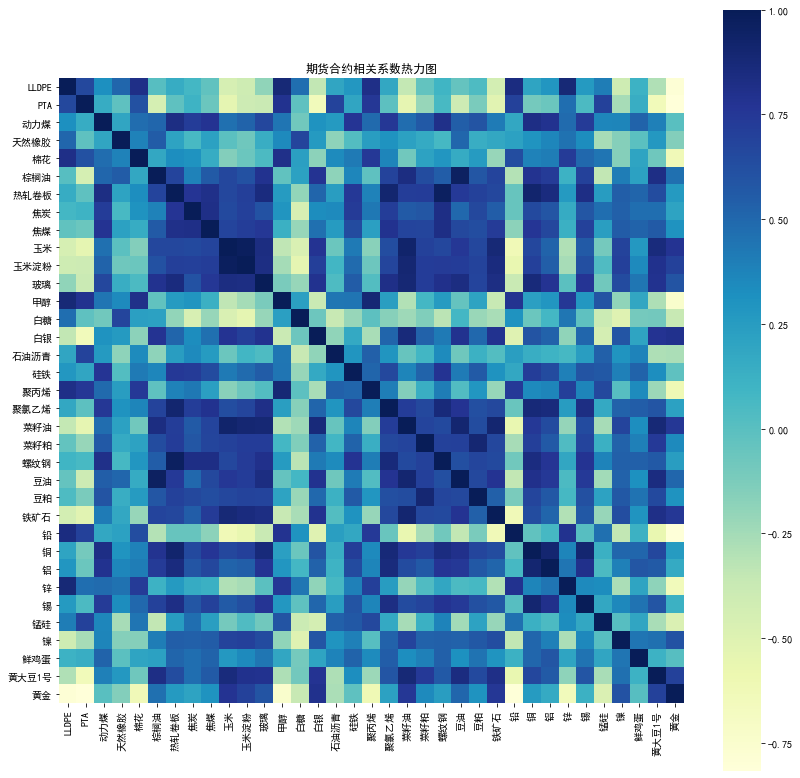

In [38]:
fig, ax = plt.subplots(figsize=(14, 14))
# 获取所有价格列表
temp = pd.DataFrame(dict(map(lambda d:(d[0], d[1].values),returns.items())))
sns.heatmap(temp.corr(), ax=ax, square=True, annot=False, yticklabels=True, cmap="YlGnBu")
ax.set_title("期货合约相关系数热力图")
plt.show()

In [ ]:
# TODO 
# 筛选前几个

In [27]:
# returns
# import matplotlibatplotlib_fname() #将会获得matplotlib包所在文件夹

In [35]:
# pd.DataFrame(data=returns)
pd.DataFrame(dict(map(lambda d:(d[0], d[1].values),returns.items()))).corr()

,LLDPE,PTA,动力煤,天然橡胶,棉花,棕榈油,热轧卷板,焦炭,焦煤,玉米,...,铅,铜,铝,锌,锡,锰硅,镍,鲜鸡蛋,黄大豆1号,黄金
LLDPE,1.000000,0.660907,0.320471,0.503497,0.819356,0.012792,0.153946,0.081958,-0.027248,-0.450836,...,0.846036,0.201872,0.285596,0.883469,0.267713,0.404484,-0.399614,0.114325,-0.289455,-0.792187
PTA,0.660907,1.000000,0.154923,-0.019439,0.611106,-0.440880,-0.019803,0.107169,-0.061321,-0.536988,...,0.699871,-0.099297,-0.060413,0.470221,0.051876,0.694981,-0.257941,0.146795,-0.635661,-0.816925
动力煤,0.320471,0.154923,1.000000,0.191311,0.476291,0.507261,0.831646,0.730085,0.778269,0.466001,...,0.181501,0.823184,0.790262,0.486721,0.733498,0.364487,0.368819,0.522659,0.395248,0.006165
天然橡胶,0.503497,-0.019439,0.191311,1.000000,0.388622,0.558007,0.211590,0.065470,0.221611,-0.005467,...,0.220907,0.298724,0.366098,0.456994,0.335336,-0.262715,-0.155448,-0.002098,0.272736,-0.145280
棉花,0.819356,0.611106,0.476291,0.388622,1.000000,0.177326,0.330728,0.309144,0.152961,-0.145952,...,0.632337,0.387847,0.405962,0.734591,0.498316,0.442267,-0.152223,0.204911,-0.072018,-0.627712
棕榈油,0.012792,-0.440880,0.507261,0.558007,0.177326,1.000000,0.684111,0.388154,0.565552,0.667102,...,-0.298864,0.780238,0.731126,0.119297,0.695694,-0.341669,0.405904,0.219361,0.829130,0.464860
热轧卷板,0.153946,-0.019803,0.831646,0.211590,0.330728,0.684111,1.000000,0.770076,0.815250,0.673305,...,-0.046874,0.915000,0.855722,0.268262,0.824927,0.249573,0.542626,0.514978,0.642162,0.262397
焦炭,0.081958,0.107169,0.730085,0.065470,0.309144,0.388154,0.770076,1.000000,0.817846,0.654622,...,-0.043449,0.654221,0.594036,0.161650,0.581894,0.472227,0.536055,0.471325,0.471424,0.207350
焦煤,-0.027248,-0.061321,0.778269,0.221611,0.152961,0.565552,0.815250,0.817846,1.000000,0.687495,...,-0.177834,0.764757,0.673241,0.129212,0.694902,0.237228,0.553976,0.524264,0.566456,0.309899
玉米,-0.450836,-0.536988,0.466001,-0.005467,-0.145952,0.667102,0.673305,0.654622,0.687495,1.000000,...,-0.624876,0.671207,0.520414,-0.290876,0.564611,-0.095055,0.691789,0.273640,0.860110,0.779095
